In [4]:
%pip install -q networkx cdlib igraph leidenalg

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\el_su\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import networkx as nx
from cdlib import algorithms, viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score

In [5]:
import os 
print(os.listdir())

['amazon_graph.graphml.xml', 'Práctica.ipynb']


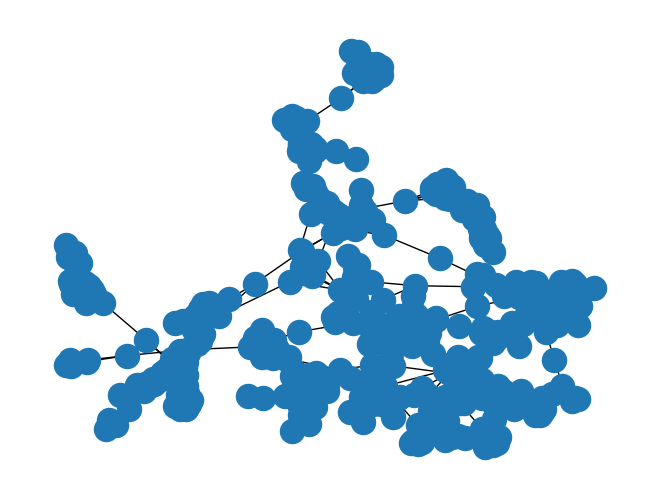

In [7]:
amazon_G = nx.read_graphml('./amazon_graph.graphml')
nx.draw(amazon_G)

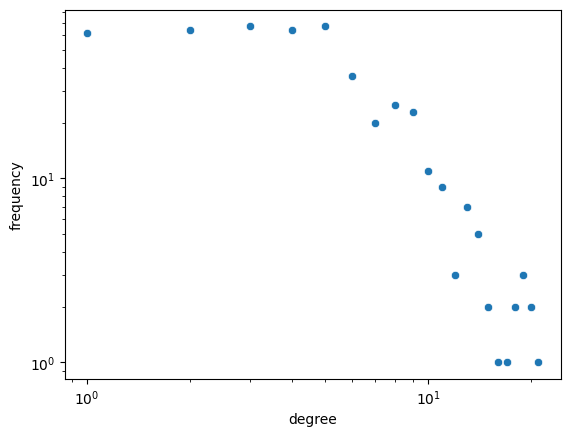

In [77]:
frequency = nx.degree_histogram(amazon_G)
data = pd.Series(frequency, name="frequency").reset_index().rename(columns={"index":"degree"})

sns.scatterplot(x="degree", y="frequency", data=data)
plt.yscale('log')
plt.xscale('log')

Radio: 14
Diametro: 28
Kemeny: 6107.80
Conectividad algebraica: 0.0014734099794685353


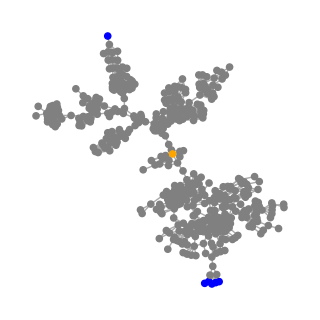

In [84]:
diameter = nx.diameter(amazon_G)
radius = nx.radius(amazon_G)

print(f"Radio: {radius}")
print(f"Diametro: {diameter}")
center = nx.center(amazon_G)
periphery = nx.periphery(amazon_G)
print(f"Kemeny: {nx.kemeny_constant(amazon_G):.2f}")
print(f"Conectividad algebraica: {nx.algebraic_connectivity(amazon_G)}")

colors = ["orange" if n in center else "blue" if n in periphery else "gray" for n in amazon_G.nodes]
plt.figure(figsize=(3,3))
nx.draw_kamada_kawai(amazon_G, node_color=colors, node_size=20, edge_color="darkgray")

Como vemos con estas metricas tenemos un grafo muy poco denso, ya que Kemeny es bastante alto y la conectividad muy baja

In [89]:
print(f"Asortativity:{nx.attribute_assortativity_coefficient(amazon_G, 'community'):.2f}")

Asortativity:0.93


Tiene sentido, ya que las comunidades ya venian hechas y se supone que deberian ser buenas comunidades

In [55]:
real_communities = [list() for _ in range(8)]
real_communities

for i in amazon_G.nodes(data=True):
    real_communities[i[1]['community']].append(i[0])

for ind, com in enumerate(real_communities):
    print(f"comunidad{ind} -> {len(com)}")

comunidad0 -> 35
comunidad1 -> 42
comunidad2 -> 24
comunidad3 -> 8
comunidad4 -> 327
comunidad5 -> 14
comunidad6 -> 16
comunidad7 -> 9


In [8]:
coms = algorithms.leiden(amazon_G)

In [9]:
from cdlib.classes.node_clustering import NodeClustering
ground_truth = NodeClustering(real_communities, amazon_G)
ground_truth.normalized_mutual_information(coms)

MatchingResult(score=0.53626503386871, std=None)

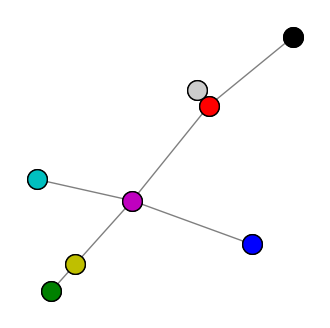

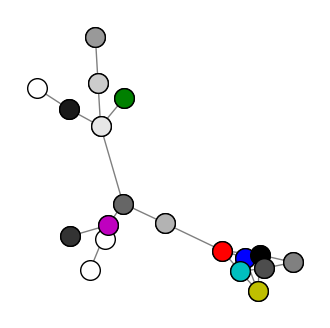

In [12]:

viz.plot_community_graph(amazon_G,ground_truth, figsize=(4,4))
viz.plot_community_graph(amazon_G,coms, figsize=(4,4))

recordemos los tamaños de las comunidades:
 ----reales---
comunidad0 -> 35
comunidad1 -> 42
comunidad2 -> 24
comunidad3 -> 8
comunidad4 -> 327
comunidad5 -> 14
comunidad6 -> 16
comunidad7 -> 9
----comunidades de leiden----
comunidad0 -> 59
comunidad1 -> 42
comunidad2 -> 42
comunidad3 -> 37
comunidad4 -> 37
comunidad5 -> 32
comunidad6 -> 30
comunidad7 -> 26
comunidad8 -> 23
comunidad9 -> 23
comunidad10 -> 18
comunidad11 -> 18
comunidad12 -> 17
comunidad13 -> 16
comunidad14 -> 15
comunidad15 -> 13
comunidad16 -> 12
comunidad17 -> 9
comunidad18 -> 6


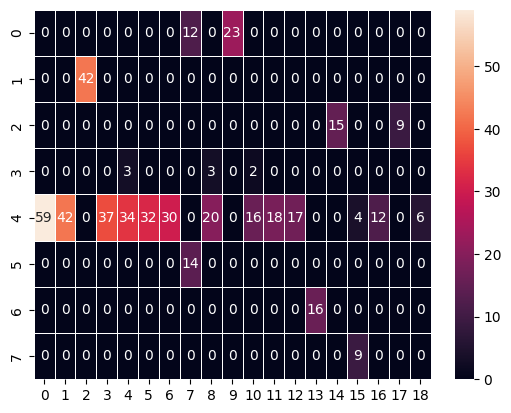

In [62]:
# HAcer la matriz donde las filas y columnas sean comunidades, unas las de verdad y otras las de leiden
# lo que habria que hacer es saber que nodos estan en que comunidades tanto en las reales como en las predichas, y entonces podemos saber cuantos nodos comparten las comunidades reales
# y las de leiden

#print(amazon_G.nodes)
matrix = np.zeros((len(ground_truth.communities), len(coms.communities)))

for node in amazon_G.nodes(data=True):
    i = node[1]['community']
    j = None
    for index, leiden_community in enumerate(coms.communities):
        if node[0] in leiden_community:
            j = index
            break
    matrix[i][j] += 1

sns.heatmap(matrix, annot= True, linewidths=.5)
print(f"recordemos los tamaños de las comunidades:\n ----reales---")
for ind, com in enumerate(real_communities):
    print(f"comunidad{ind} -> {len(com)}")
print(f"----comunidades de leiden----")
for ind, com in enumerate(coms.communities):
    print(f"comunidad{ind} -> {len(com)}")

vamos a analizar un poquito como se han dividido los grupos

In [73]:
for index, fila in enumerate(matrix):
    total = np.sum(fila)
    print(f"\nLa comunidad{index} con {total} nodos se ha dividido en:")
    for index, columna in enumerate(fila):
        if columna != 0:
            print(f"comunidad{index} {columna*100 / total}%")
        


La comunidad0 con 35.0 nodos se ha dividido en:
comunidad7 34.285714285714285%
comunidad9 65.71428571428571%

La comunidad1 con 42.0 nodos se ha dividido en:
comunidad2 100.0%

La comunidad2 con 24.0 nodos se ha dividido en:
comunidad14 62.5%
comunidad17 37.5%

La comunidad3 con 8.0 nodos se ha dividido en:
comunidad4 37.5%
comunidad8 37.5%
comunidad10 25.0%

La comunidad4 con 327.0 nodos se ha dividido en:
comunidad0 18.04281345565749%
comunidad1 12.844036697247706%
comunidad3 11.314984709480122%
comunidad4 10.397553516819572%
comunidad5 9.785932721712538%
comunidad6 9.174311926605505%
comunidad8 6.116207951070336%
comunidad10 4.892966360856269%
comunidad11 5.504587155963303%
comunidad12 5.198776758409786%
comunidad15 1.2232415902140672%
comunidad16 3.669724770642202%
comunidad18 1.834862385321101%

La comunidad5 con 14.0 nodos se ha dividido en:
comunidad7 100.0%

La comunidad6 con 16.0 nodos se ha dividido en:
comunidad13 100.0%

La comunidad7 con 9.0 nodos se ha dividido en:
comun

Como vemos lo que ha ocurrido ha sido que principalmente la comunidad mas grande se ha expandido en varias comunidades, siendo un fallo del algoritmo de leiden, no consiguiendo crear comunidades muy grandes y muy pequeñas en el mismo grafo, si o que tiende a crear comunidades del mismo tamaño mas o menos

In [68]:
print(f"vamos a comprobar que siguen dando el mismo numero de nodos")
print(f"-----por filas-----")
for index, fila in enumerate(matrix):
    
    print(f"comunidad{index} -> {np.sum(fila)}")
print("-----por columnas-----")

for index in range(matrix.shape[1]):
    print(f"comunidad{index} -> {np.sum(matrix[:, index])}")

vamos a comprobar que siguen dando el mismo numero de nodos
-----por filas-----
comunidad0 -> 35.0
comunidad1 -> 42.0
comunidad2 -> 24.0
comunidad3 -> 8.0
comunidad4 -> 327.0
comunidad5 -> 14.0
comunidad6 -> 16.0
comunidad7 -> 9.0
-----por columnas-----
comunidad0 -> 59.0
comunidad1 -> 42.0
comunidad2 -> 42.0
comunidad3 -> 37.0
comunidad4 -> 37.0
comunidad5 -> 32.0
comunidad6 -> 30.0
comunidad7 -> 26.0
comunidad8 -> 23.0
comunidad9 -> 23.0
comunidad10 -> 18.0
comunidad11 -> 18.0
comunidad12 -> 17.0
comunidad13 -> 16.0
comunidad14 -> 15.0
comunidad15 -> 13.0
comunidad16 -> 12.0
comunidad17 -> 9.0
comunidad18 -> 6.0
